In [1]:
for name in dir():
 if not name.startswith("_"):
   del globals()[name]

In [2]:
#Import necessary packages
import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import graphviz
import itertools
import pickle

from scipy.stats import ks_2samp
from scipy.stats import chi2_contingency
from scipy.stats import chi2

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from scipy import interp
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from joblib import Parallel, delayed

/Users/parthankasarapu/anaconda2/envs/py36/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
df_train_transaction = pd.read_csv('./data/train_transaction.csv', header='infer')
df_test_transaction = pd.read_csv('./data/test_transaction.csv', header='infer')

df_train_identity = pd.read_csv('./data/train_identity.csv', header='infer')
df_test_identity = pd.read_csv('./data/test_identity.csv', header='infer')

sample_submission = pd.read_csv('./data/sample_submission.csv', header='infer')

In [4]:
df_train_identity.head(10)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
5,2987017,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,3.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,18.0,529.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 10,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
6,2987022,-15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987038,0.0,31964.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,15.0,352.0,533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android,chrome 62.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,NaN
8,2987040,-10.0,116098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
9,2987048,-5.0,257037.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,484.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [4]:
df_train_full = df_train_transaction.merge(df_train_identity, how='left', on='TransactionID')
df_test_full = df_test_transaction.merge(df_test_identity, how='left', on='TransactionID')

print(df_train_full.shape)
print(df_test_full.shape)

(590540, 434)
(506691, 433)


In [6]:
del df_train_transaction, df_test_transaction, df_train_identity, df_test_identity

In [5]:
df_train_full.head(20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,117.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,117.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,

In [7]:
if 0:
    # Drop target, fill in NaNs
    X_train = train.drop('isFraud', axis=1)
    X_test = test.copy()
    X_train = X_train.fillna(-999)
    X_test = X_test.fillna(-999)

    # Label Encoding
    for f in X_train.columns:
        if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(X_train[f].values) + list(X_test[f].values))
            X_train[f] = lbl.transform(list(X_train[f].values))
            X_test[f] = lbl.transform(list(X_test[f].values))   

    sample_submission['isFraud'] = clf.predict_proba(X_test)[:,1]
    sample_submission.to_csv('./data/results/simple_xgboost.csv')

In [8]:
df_train_full['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [6]:
def check_missing(df):
    df_missing = pd.concat([df.nunique(), df.isnull().any(), df.isnull().sum()], axis=1)
    df_missing.columns = ['nunique', 'isnull_any', 'isnull_count']
    df_missing['missing'] = df_missing['isnull_count'] / float(len(df))
    return (df_missing)

In [7]:
%%time
if 0:
    df0 = df_train_full[ df_train_full['isFraud'] == 0 ]
    df0_missing = check_missing(df0)

    df1 = df_train_full[ df_train_full['isFraud'] == 1 ]
    df1_missing = check_missing(df1)
    df_missing = pd.merge(df0_missing, df1_missing, how="left", left_index=True, right_index=True)
    df_missing.to_pickle('./data/pickles/approach2/df_missing.pkl')
else:
    df_missing = pd.read_pickle('./data/pickles/approach2/df_missing.pkl')

CPU times: user 1.95 ms, sys: 850 µs, total: 2.8 ms
Wall time: 2.16 ms


In [8]:
df_missing

,nunique_x,isnull_any_x,isnull_count_x,missing_x,nunique_y,isnull_any_y,isnull_count_y,missing_y
TransactionID,569877,False,0,0.000000,20663,False,0,0.000000
isFraud,1,False,0,0.000000,1,False,0,0.000000
TransactionDT,553717,False,0,0.000000,20638,False,0,0.000000
TransactionAmt,20560,False,0,0.000000,2515,False,0,0.000000
ProductCD,5,False,0,0.000000,5,False,0,0.000000
card1,13350,False,0,0.000000,1740,False,0,0.000000
card2,500,True,8510,0.014933,327,True,423,0.020471
card3,106,True,1526,0.002678,62,True,39,0.001887
card4,4,True,1536,0.002695,4,True,41,0.001984
card5,118,True,4049,0.007105,49,True,210,0.010163


In [19]:
df_train_full.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,421571.000000,421571.000000,421571.000000,421571.00000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,590226.000000,590226.00000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.0000

In [9]:
all_columns = df_train_full.columns.tolist()

In [10]:
# all_cat_features (from df_train_transaction)
all_cat_features = [
                'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
                'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 
                'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9' 
              ]

# other_cat_features (from df_train_identity)
other_cat_features = pd.Series(np.arange(12, 39)).apply(str).apply(lambda x : 'id_' + x).tolist()
other_cat_features += ['DeviceType', 'DeviceInfo']
all_cat_features.extend(other_cat_features)

excl_columns = all_cat_features + ['TransactionID', 'isFraud', 'TransactionDT']

all_num_features = [col for col in all_columns if col not in excl_columns]

In [11]:
print(len(excl_columns))
print(len(all_cat_features))
print(len(all_num_features))

52
49
382


In [12]:
#-------------------------------------------------------------------------------
# Computes the statistical distance between two samples using the KS-test.
# This is used to determine if the distribution of the attribute columns are
# statistically different when failure = 0 and failure = 1.
#-------------------------------------------------------------------------------
def compute_statistical_distance(df, feature):
    s0 = df[ df['isFraud'] == 0 ][feature]
    s1 = df[ df['isFraud'] == 1 ][feature]
    
    a0 = s0[ ~s0.isna() ]
    a1 = s1[ ~s1.isna() ]
    compare = ks_2samp(a0, a1)
    
    return ([feature, compare.statistic, compare.pvalue])

In [13]:
%%time
if 0:
    compare_lists = []
    i = 0
    for col in all_num_features:
        i += 1
        result = compute_statistical_distance(df_train, col)
        print(i, col)
        compare_lists.append(result)

    df_compare = pd.DataFrame.from_records(compare_lists, columns=['feature', 'statistic', 'pvalue'])
    df_compare.to_pickle('./data/pickles/approach2/df_kstest_comparison.pkl')
else: 
    df_compare = pd.read_pickle('./data/pickles/approach2/df_kstest_comparison.pkl')

CPU times: user 1.34 ms, sys: 850 µs, total: 2.19 ms
Wall time: 1.56 ms


In [14]:
df_compare

,feature,statistic,pvalue
0,TransactionAmt,0.075649,1.533201e-99
1,dist1,0.109743,3.564254e-49
2,dist2,0.073436,3.607917e-16
3,C1,0.187575,0.000000e+00
4,C2,0.204344,0.000000e+00
5,C3,0.004012,9.053311e-01
6,C4,0.330962,0.000000e+00
7,C5,0.287236,0.000000e+00
8,C6,0.132835,4.940649e-306
9,C7,0.278473,0.000000e+00


In [15]:
# 1. Remove numerical features based on KS significance test
removed_features_kstest = df_compare[ df_compare['pvalue'] > 0.01 ]['feature'].tolist()
numeric_features = sorted(df_compare[ df_compare['pvalue'] <= 0.01 ].sort_values(by='pvalue', ascending=False)['feature'].tolist())
print(len(removed_features_kstest))
print(len(numeric_features))

38
344


In [16]:
df_numeric = df_train_full[numeric_features].copy()

In [17]:
df_numeric.head()

,C1,C10,C11,C12,C13,C14,C2,C4,C5,C6,C7,C8,C9,D1,D10,D11,D12,D13,D14,D15,D2,D3,D4,D5,D6,D7,D8,D9,TransactionAmt,V10,V100,V101,V102,V103,V104,V105,V106,V108,V109,V11,V110,V111,V112,V113,V114,V115,V116,V12,V123,V124,V125,V126,V127,V128,V129,V13,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V15,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V16,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V17,V170,V171,V174,V175,V176,V177,V178,V179,V18,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V19,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V2,V20,V200,V201,V202,V203,V204,V208,V209,V21,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V22,V220,V221,V222,V224,V225,V226,V227,V228,V229,V23,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V24,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V26,V260,V261,V262,V263,V264,V265,V267,V268,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V287,V288,V289,V29,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V3,V30,V300,V301,V302,V303,V304,V306,V307,V308,V309,V31,V310,V312,V313,V314,V315,V316,V317,V318,V319,V32,V320,V321,V322,V323,V324,V326,V327,V328,V329,V33,V330,V331,V332,V333,V335,V336,V337,V338,V339,V34,V35,V36,V37,V38,V39,V4,V40,V42,V43,V44,V45,V46,V47,V48,V49,V5,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V66,V67,V69,V7,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V9,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,dist1,dist2,id_01,id_02,id_03,id_05,id_06,id_07,id_08,id_09
0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,14.0,13.0,13.0,NaN,NaN,NaN,0.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,68.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,1.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,29.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [18]:
%%time
if 0:
    corr_matrix = df_numeric.corr()
    corr_matrix.to_pickle('./data/pickles/approach2/corr_matrix.pkl')
else:
    corr_matrix = pd.read_pickle('./data/pickles/approach2/corr_matrix.pkl')

CPU times: user 1.63 ms, sys: 2.1 ms, total: 3.73 ms
Wall time: 2.55 ms


In [19]:
corr_matrix.shape

(344, 344)

In [20]:
def collinearity_data_frame(upper, to_drop, threshold=0.95):
    record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

    # Iterate through the columns to drop
    for column in to_drop:
        # Find the correlated features
        corr_features = list(upper.index[upper[column].abs() > threshold])

        # Find the correlated values
        corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
        drop_features = [column for _ in range(len(corr_features))]    

        # Record the information (need a temp df for now)
        temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': corr_features,
                                             'corr_value': corr_values})

        # Add to dataframe
        record_collinear = record_collinear.append(temp_df, ignore_index = True)
        
    return(record_collinear)

In [21]:
correlation_threshold = 0.95
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

In [22]:
len(to_drop)

131

In [23]:
record_collinear = collinearity_data_frame(upper, to_drop)
record_collinear['drop_feature'].value_counts()
record_collinear

,drop_feature,corr_feature,corr_value
0,C10,C1,0.958202
1,C11,C1,0.996515
2,C11,C10,0.956056
3,C12,C10,0.983817
4,C14,C1,0.951761
5,C14,C11,0.962465
6,C2,C1,0.995089
7,C2,C10,0.970624
8,C2,C11,0.993898
9,C4,C1,0.967800


In [29]:
import seaborn as sns

def plot_collinear(corr_matrix, record_collinear):
    """
    Heatmap of the features with correlations above the correlated threshold in the data.

    Notes
    --------
    - Not all of the plotted correlations are above the threshold because this plots
      all the variables that have been idenfitied as having even one correlation above the threshold
    - The features on the x-axis are those that will be removed. The features on the y-axis
      are the correlated feature with those on the x-axis

    """

    if record_collinear is None:
        raise NotImplementedError('Collinear features have not been idenfitied. Run `identify_collinear`.')

    # Identify the correlations that were above the threshold
    corr_matrix_plot = corr_matrix.loc[list(set(record_collinear['corr_feature'])), 
                                                    list(set(record_collinear['drop_feature']))]

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 8))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix_plot, cmap=cmap, center=0,
                        linewidths=.25, cbar_kws={"shrink": 0.6})

    ax.set_yticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[0]))])
    ax.set_yticklabels(list(corr_matrix_plot.index), size = int(160 / corr_matrix_plot.shape[0]));

    ax.set_xticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[1]))])
    ax.set_xticklabels(list(corr_matrix_plot.columns), size = int(160 / corr_matrix_plot.shape[1]));

    plt.xlabel('Features to Remove', size = 8); plt.ylabel('Correlated Feature', size = 8)
    plt.title("Correlations Above Threshold", size = 14)

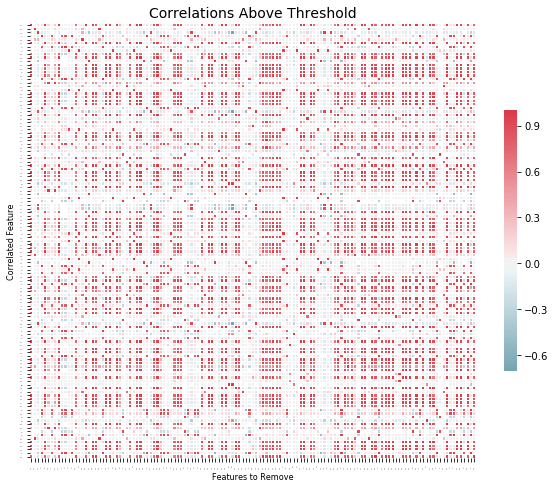

In [30]:
plot_collinear(corr_matrix, record_collinear)

In [24]:
# 2. Remove numerical features based on collinearity
removed_features_collinear = to_drop
numeric_features = [col for col in numeric_features if col not in removed_features_collinear]
print(len(to_drop))
print(len(numeric_features))

131
213


In [25]:
# 3. Remove features with large number of missing data values
max_missing_percent = 0.8
missing_features_all = df_missing[ df_missing['missing_x'] > max_missing_percent ].index.tolist()
print(len(missing_features_all))

numeric_features = [col for col in numeric_features if col not in missing_features_all]
print(len(numeric_features))

cat_features = [col for col in all_cat_features if col not in missing_features_all]
print(len(cat_features))

75
183
35


In [26]:
cat_features

['ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_13',
 'id_15',
 'id_16',
 'id_17',
 'id_19',
 'id_20',
 'id_28',
 'id_29',
 'id_31',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType']

In [32]:
np.isin(df_train_identity.columns, numeric_features)

array([False,  True,  True, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [27]:
def categorical_correlation(df, f1, f2, threshold=0.95):
    df_tmp = df[['TransactionID', f1, f2]].copy()
    dfc = df_tmp.groupby([f1, f2]).count().reset_index()
    dfcp = dfc.pivot(index=f1, columns=f2, values='TransactionID').fillna(0)
    corr = 0
    if len(dfcp) > 0:
        table = dfcp.values.tolist()

        stat, p, dof, expected = chi2_contingency(table)

        # interpret test-statistic
        #critical = chi2.ppf(threshold, dof)
        alpha = 1.0 - threshold
        corr = 1 - p
    
    #if p <= alpha:
    #    print('Dependent (reject H0)')
    #else:
    #    print('Independent (fail to reject H0)')
    
    return (corr)

In [82]:
m = len(cat_features)
print(m)

35


In [86]:
%%time
if 0:
    corr_matrix2 = pd.DataFrame(np.zeros((m, m)), index=cat_features, columns=cat_features)
    for i in range(m):
        f1 = cat_features[i]
        for j in range(i+1, m):
            #print (i, j)
            f2 = cat_features[j]
            corr_matrix2.loc[f1, f2] = categorical_correlation(df_train_full, f1, f2)
    corr_matrix2.to_pickle('./data/pickles/approach2/corr_matrix2.pkl')
else:
    corr_matrix2 = pd.read_pickle('./data/pickles/approach2/corr_matrix2.pkl')

CPU times: user 1.3 ms, sys: 1.13 ms, total: 2.43 ms
Wall time: 1.51 ms


In [87]:
corr_matrix2.shape

(35, 35)

In [88]:
correlation_threshold = 0.95
upper = corr_matrix2.where(np.triu(np.ones(corr_matrix2.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]
len(to_drop)

34

In [89]:
record_collinear = collinearity_data_frame(upper, to_drop)
record_collinear.sort_values('corr_value', ascending=True)

,drop_feature,corr_feature,corr_value
127,M7,M5,0.988470
110,M6,addr2,0.989910
132,M8,card4,0.997182
98,M5,addr2,0.998737
151,M9,M1,0.999192
154,M9,M4,0.999447
89,M4,M2,0.999516
71,M3,card4,0.999890
134,M8,card6,0.999914
118,M7,card3,0.999971


In [90]:
# 4. Remove categorical features based on collinearity
removed_features_collinear = to_drop
cat_features = [col for col in cat_features if col not in removed_features_collinear]
print(len(to_drop))
print(cat_features)

34
['ProductCD']


In [91]:
# imputation methods

def impute_missing_numeric(df, replace):
    for col in df.columns.tolist():
        df[col].fillna(replace[col], inplace=True)
        
def impute_missing_categorical(df):
    for col in df.columns.tolist():
        #df[col].fillna('NA', inplace=True)
        df[col] = df[col].map(lambda x: str(x).rstrip('.0'))

In [92]:
def prepare_training_data(df_train_full, numeric_features, cat_features):
    df_numeric_train = df_train_full[numeric_features].copy()
    df_categorical_train = df_train_full[cat_features].copy()
    
    # replacement strategy
    replace_num = np.mean(df_numeric_train)
    
    # imputation of missing fature values
    # imputing numeric features
    impute_missing_numeric(df_numeric_train, replace_num)
    
    # imputing categorical features
    #impute_missing_categorical(df_categorical_train)
    
    encoding_cat = OneHotEncoder()
    encoding_cat.fit(df_categorical_train)
    df_categorical_train_enc = pd.DataFrame(
        encoding_cat.transform(df_categorical_train).toarray(), columns=encoding_cat.get_feature_names()
    )
    
    df_train = df_train_full[['TransactionID', 'isFraud']].copy()
    df_train = pd.merge(df_train, df_categorical_train_enc, how='left', left_index=True, right_index=True)
    df_train = pd.merge(df_train, df_numeric_train, how='left', left_index=True, right_index=True)
    
    return (df_train, replace_num, encoding_cat)

In [93]:
def prepare_testing_data(
        df_test_full, numeric_features, cat_features, replace_num, encoding_cat
):
    df_numeric_test = df_test_full[numeric_features].copy()
    df_categorical_test = df_test_full[cat_features].copy()
    
    # imputation of missing values
    # numeric features
    impute_missing_numeric(df_numeric_test, replace_num)
    
    # imputing categorical features
    #impute_missing_categorical(df_categorical_test)
    df_categorical_test_enc = pd.DataFrame(
        encoding_cat.transform(df_categorical_test).toarray(), columns=encoding_cat.get_feature_names()
    )
    
    df_test = df_test_full[['TransactionID']].copy()
    df_test = pd.merge(df_test, df_categorical_test_enc, how='left', left_index=True, right_index=True)
    df_test = pd.merge(df_test, df_numeric_test, how='left', left_index=True, right_index=True)
    
    return (df_test)

In [94]:
%%time
if 0:
    df_train, replace_num, encoding_cat = prepare_training_data(df_train_full, numeric_features, cat_features)
    df_train.to_pickle('./data/pickles/approach2/df_train.pkl')
else:
    df_train = pd.read_pickle('./data/pickles/approach2/df_train.pkl')

CPU times: user 271 ms, sys: 737 ms, total: 1.01 s
Wall time: 1.01 s


In [95]:
print(df_train.shape)
df_train.head()

(590540, 190)


,TransactionID,isFraud,x0_C,x0_H,x0_R,x0_S,x0_W,C1,C13,C5,C9,D1,D10,D11,D15,D3,D5,TransactionAmt,V10,V100,V101,V102,V104,V105,V108,V109,V110,V111,V112,V113,V114,V115,V116,V12,V123,V124,V125,V129,V13,V130,V131,V135,V136,V137,V15,V169,V17,V170,V171,V174,V175,V176,V180,V181,V183,V184,V185,V186,V187,V188,V189,V19,V190,V191,V194,V195,V197,V198,V2,V20,V200,V201,V203,V208,V209,V210,V214,V215,V216,V218,V220,V221,V224,V226,V227,V228,V229,V23,V230,V234,V235,V238,V239,V24,V242,V243,V245,V246,V247,V248,V250,V252,V255,V257,V258,V259,V26,V260,V261,V262,V264,V267,V268,V270,V271,V274,V281,V282,V283,V284,V285,V287,V288,V289,V29,V290,V291,V297,V3,V300,V301,V302,V303,V309,V31,V310,V312,V313,V314,V315,V319,V320,V321,V35,V36,V37,V38,V39,V4,V40,V42,V44,V45,V46,V47,V48,V5,V51,V53,V54,V55,V56,V59,V61,V62,V64,V66,V67,V69,V7,V73,V75,V76,V77,V78,V79,V80,V82,V83,V85,V86,V87,V9,V90,V98,dist1,id_01,id_02,id_05,id_06
0,2987000,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,14.0,13.000000,13.000000,0.000000,13.000000,42.335965,68.5,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.168053,0.00000,1.436779,1.690908,0.127794,0.212639,1.376979,0.924123,0.253332,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,1.000000,1.213083,1.058984,0.945773,0.954227,0.949385,0.961951,1.000000,1.000000,1.119977,1.159106,1078.327538,8.888193,35.001872,14.391835,38.437547,133.208217,71.107143,1.725784,0.169472,1.274912,0.394748,0.247612,0.147975,1.351928,1.63871,1.000000,1.465476,2.092847,0.184106,0.127956,0.136965,1.000000,1.113463,1.178387,0.876619,1.183723,1.025355,1.069493,0.788588,1.032048,0.806656,1.250993,1.34351,0.967832,1.00000,0.964425,1.107161,1.013279,201.657617,36.525103,18.813407,7.712764,9.445133,107.151636,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.542594,0.579198,1.108065,1.1624,0.166076,1.000000,0.177145,0.156118,1.083891,1.120779,1.022286,1.038515,0.383174,1.000000,0.170579,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.0000,1.00000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.0,19.00000,-10.170502,174716.584708,1.615585,-6.69871
1,2987001,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,146.621465,0.000000,28.343348,42.335965,29.0,0.463915,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.168053,0.00000,1.436779,1.690908,0.127794,0.212639,1.376979,0.924123,0.253332,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,1.000000,1.213083,1.058984,0.945773,0.954227,0.949385,0.961951,1.045204,1.000000,1.119977,1.159106,1078.327538,8.888193,35.001872,14.391835,38.437547,133.208217,71.107143,1.725784,0.169472,1.274912,0.394748,0.247612,0.147975,1.351928,1.63871,1.000000,1.465476,2.092847,0.184106,0.127956,0.136965,1.000000,1.113463,1.178387,0.876619,1.183723,1.025355,1.069493,0.788588,1.032048,0.806656,1.250993,1.34351,0.967832,1.00000,0.964425,1.107161,1.013279,201.657617,36.525103,18.813407,7.712764,9.445133,107.151636,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,1.0,0.0,1.078075,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,1.0000,0.000000,0.846456,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.876991,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.0000,1.07287,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,1.000000,0.000000,1.000000,1.000000,1.041529,0.000000,0.0,118.50218,-10.170502,174716.584708,1.615585,-6.69871
2,2987002,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.000000,315.000000,315.000000,28.343348,42.335965,59.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.168053,0.000

In [96]:
%%time
if 0:
    df_test = prepare_testing_data(df_test_full, numeric_features, cat_features, replace_num, encoding_cat)
    df_test.to_pickle('./data/pickles/approach2/df_test.pkl')
else:
    df_test = pd.read_pickle('./data/pickles/approach2/df_test.pkl')

CPU times: user 201 ms, sys: 615 ms, total: 816 ms
Wall time: 819 ms


In [64]:
print(df_test.shape)
df_test.head()

(506691, 189)


,TransactionID,x0_C,x0_H,x0_R,x0_S,x0_W,C1,C13,C5,C9,D1,D10,D11,D15,D3,D5,TransactionAmt,V10,V100,V101,V102,V104,V105,V108,V109,V110,V111,V112,V113,V114,V115,V116,V12,V123,V124,V125,V129,V13,V130,V131,V135,V136,V137,V15,V169,V17,V170,V171,V174,V175,V176,V180,V181,V183,V184,V185,V186,V187,V188,V189,V19,V190,V191,V194,V195,V197,V198,V2,V20,V200,V201,V203,V208,V209,V210,V214,V215,V216,V218,V220,V221,V224,V226,V227,V228,V229,V23,V230,V234,V235,V238,V239,V24,V242,V243,V245,V246,V247,V248,V250,V252,V255,V257,V258,V259,V26,V260,V261,V262,V264,V267,V268,V270,V271,V274,V281,V282,V283,V284,V285,V287,V288,V289,V29,V290,V291,V297,V3,V300,V301,V302,V303,V309,V31,V310,V312,V313,V314,V315,V319,V320,V321,V35,V36,V37,V38,V39,V4,V40,V42,V44,V45,V46,V47,V48,V5,V51,V53,V54,V55,V56,V59,V61,V62,V64,V66,V67,V69,V7,V73,V75,V76,V77,V78,V79,V80,V82,V83,V85,V86,V87,V9,V90,V98,dist1,id_01,id_02,id_05,id_06
0,3663549,0.0,0.0,0.0,0.0,1.0,6.0,115.0,3.0,6.0,419.0,418.0,203.0,409.0,27.0,27.0,31.95,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.000000,0.0,47.950001,0.000000,0.0,0.0,0.0,0.0,0.168053,0.0,1.436779,1.690908,0.127794,0.212639,1.376979,0.924123,0.253332,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,0.0,1.213083,1.058984,0.945773,0.954227,0.949385,0.961951,1.0,0.0,1.119977,1.159106,1078.327538,8.888193,35.001872,14.391835,38.437547,133.208217,71.107143,1.725784,0.169472,1.274912,0.394748,0.247612,0.147975,1.351928,1.63871,1.0,1.465476,2.092847,0.184106,0.127956,0.136965,1.0,1.113463,1.178387,0.876619,1.183723,1.025355,1.069493,0.788588,1.032048,0.806656,1.250993,1.34351,0.967832,0.0,0.964425,1.107161,1.013279,201.657617,36.525103,18.813407,7.712764,9.445133,107.151636,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,47.950001,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,-10.170502,174716.584708,1.615585,-6.69871
1,3663550,0.0,0.0,0.0,0.0,1.0,3.0,12.0,0.0,2.0,149.0,231.0,634.0,634.0,7.0,7.0,49.00,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,280.000000,77.000000,0.0,0.0,0.0,0.0,0.168053,0.0,1.436779,1.690908,0.127794,0.212639,1.376979,0.924123,0.253332,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,1.0,1.213083,1.058984,0.945773,0.954227,0.949385,0.961951,1.0,1.0,1.119977,1.159106,1078.327538,8.888193,35.001872,14.391835,38.437547,133.208217,71.107143,1.725784,0.169472,1.274912,0.394748,0.247612,0.147975,1.351928,1.63871,1.0,1.465476,2.092847,0.184106,0.127956,0.136965,1.0,1.113463,1.178387,0.876619,1.183723,1.025355,1.069493,0.788588,1.032048,0.806656,1.250993,1.34351,0.967832,1.0,0.964425,1.107161,1.013279,201.657617,36.525103,18.813407,7.712764,9.445133,107.151636,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,280.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,4.0,-10.170502,174716.584708,1.615585,-6.69871
2,3663551,0.0,0.0,0.0,0.0,1.0,2.0,22.0,0.0,4.0,137.0,136.0,136.0,97.0,10.0,10.0,171.00,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,705.000000,0.000000,0.0,263.0,0.0,0.0,0.168053,0.0,1.436779,1.690908,0.127794,0.212639,1.376979,0.924123,0.253332,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,1.0,1.213083,1.058984,0.945773,0.954227,0.949385,0.961951,1.0,1.0,1.119977,1.159106,1078.327538,8.888193,35.001872,14.391835,38.437547,133.208217,71.107143,1.725784,0.169472,1.274912,0.394748,0.247612,0.147975,1.351928,1.63871,2.0,1.465476,2.092847,0.184106,0.127956,0.136965,2.0,1.113463,1.178387,0.876619,1.183723,1.025355,1.069493,0.788588,1.032048,0.806656,1.250993,1.34351,0.967832,1

In [97]:
model_features = [f for f in df_train.columns.tolist() if f not in ['TransactionID', 'isFraud']]

In [139]:
crossvalidation = StratifiedKFold(n_splits = 3)
scoring_metrics = {
                    'Accuracy': 'accuracy',
                    'Recall': 'recall',
                    'Precision': 'precision',
                    'F1': 'f1',
                    'AUC': 'roc_auc'
                  }

In [132]:
#-------------------------------------------------------------------------------
# Instantiate the machine learning models with their respective parameters for
# cross-validation.
#-------------------------------------------------------------------------------
def instantiate(model_type):
    if model_type == 'Decision Tree':
        MAX_HEIGHT = 20
        model = DecisionTreeClassifier(random_state=0)
        model_parameter_grid = {
         'max_depth': range(1,(MAX_HEIGHT+1))
        }
    elif model_type == 'Neural Network':
        NUM_HIDDEN_LAYERS = 2
        NUM_HIDDEN_NODES_PER_LAYER = 4
        model = MLPClassifier(
                  solver='adam',
                  activation='logistic',
                  alpha=0.1,
                  learning_rate='adaptive',
                  shuffle=False,
                  random_state=0
                )
        model_parameter_grid = {
          #'activation': ['identity', 'logistic', 'tanh'],
          #'learning_rate': ['invscaling', 'adaptive'],
          #'alpha': [0.01, 0.1, 1.0],
          'hidden_layer_sizes': [x for x in itertools.product((range(1,(NUM_HIDDEN_NODES_PER_LAYER+1))), repeat=NUM_HIDDEN_LAYERS)]
        }
    elif model_type == 'Logistic Regression':
        model = LogisticRegression(
                    class_weight='balanced',
                    random_state=0
                )
        model_parameter_grid = {
            'C': [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 2, 5, 10]
        }
    elif model_type == 'Random Forest':
        MAX_HEIGHT = 15
        NUM_TREES = 20
        model = RandomForestClassifier(random_state=0, class_weight='balanced')
        model_parameter_grid = {
          'max_depth': range(5,(MAX_HEIGHT+1)),
          'n_estimators': [x for x in range(1, (NUM_TREES+1))]
        }
    elif model_type == 'LightGBM':
        MAX_HEIGHT = 10
        NUM_TREES = 10
        model = LGBMClassifier(
                    boosting_type= 'gbdt',
                    objective = 'binary',
                    class_weight = 'balanced',
                    learning_rate = 0.1,
                    random_state=0
                )
        model_parameter_grid = {
            'max_depth': range(5,(MAX_HEIGHT+1)),
            'n_estimators': [x for x in range(5, (NUM_TREES+1))]
        }
    elif model_type == 'XGBoost':
        MAX_HEIGHT = 10
        NUM_TREES = 20
        model = XGBClassifier(
                    objective='binary:logistic', 
                    booster='gbtree',
                    learning_rate=0.1,
                    random_state=0
                )
        model_parameter_grid = {
            'max_depth': range(5,(MAX_HEIGHT+1)),
            'n_estimators': [x for x in range(5, (NUM_TREES+1))]
        }

    return model, model_parameter_grid

In [133]:
#-------------------------------------------------------------------------------
# Graphs the outputs of the cross-validation optimization process for the
# __Decision Tree__ model (this function can be extended to any model which has a
# single changeable hyperparameter).
#
# Produces comparison of the different evaluation metrics for
# training & testing data splits.
#-------------------------------------------------------------------------------
def plot_cross_validation_output(grid_search_output, scoring_metrics, max_height):
    fig = plt.figure(figsize=(20, 10))
    plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
              fontsize=12)

    plt.xlabel("DecisionTree Height")
    plt.ylabel("Score")

    ax = plt.gca()
    ax.set_xticks(np.linspace(0, max_height, max_height+1))
    ax.set_ylim(0, 1.05)

    # Set X-axis to be the Decision Tree height
    X_axis = np.array(grid_search_output['param_max_depth'], dtype=int)

    for scorer, color in zip(scoring_metrics, ['r', 'b', 'm', 'g', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = grid_search_output['mean_%s_%s' % (sample, scorer)]
            sample_score_std = grid_search_output['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(grid_search_output['rank_test_%s' % scorer] == 1)[0][0]
        best_score = grid_search_output['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    #plt.legend(loc="best")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid('off')
    plt.show()

    results_dir = './data/results/approach2/'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    filename = 'decision_tree_evaluation.png'
    filepath= os.path.join(results_dir, filename)
    fig.savefig(filepath, bbox_inches = 'tight')


In [134]:
#-------------------------------------------------------------------------------
# Postprocessing the optimal machine learning model to print out the Tree.
#-------------------------------------------------------------------------------
def post_process(model_type, optimal_model, X):
    if model_type == 'Decision Tree':
        # Print the optimal decision tree (takes time to output if the tree is lengthy)
        outfile = 'tree'
        outfile_path = os.path.join('./data/results/approach2/', outfile)
        print('Exporting the optimal Decision Tree to %s ...' % outfile_path)
        dot_data = export_graphviz(optimal_model, out_file=None, feature_names=X.columns, rounded=True)
        graph = graphviz.Source(dot_data)
        graph.render(outfile_path)

In [135]:
#-------------------------------------------------------------------------------
# Execute the cross-validation for all parameter combinations and plots the
# evaluation metrics. At each iteration of the cross validation process, the 
# model is evaluated using all the below metrics but the optimal model is 
# determined using the AUC score (as this minimizes both false positives &
# false negatives).
#-------------------------------------------------------------------------------
def build_optimal_model(model_type, model, model_parameter_grid, X, y, crossvalidation, scoring_metrics):
    grid_object = GridSearchCV(model, param_grid=model_parameter_grid, cv=crossvalidation, scoring=scoring_metrics, refit='AUC', return_train_score=True, n_jobs=-1)
    print('Performing grid search to determine the optimal parameters ...')
    grid_object.fit(X, y)
    grid_search_output = pd.DataFrame(grid_object.cv_results_)
    grid_search_output[['params', 'mean_test_AUC', 'rank_test_AUC', 'mean_test_Recall', 'rank_test_Recall', 'mean_test_Accuracy', 'rank_test_Accuracy']]

    if model_type == 'Decision Tree':
        MAX_HEIGHT = 20
        plot_cross_validation_output(grid_search_output, scoring_metrics, MAX_HEIGHT)

    optimal_model = grid_object.best_estimator_
    optimal_model = optimal_model.fit(X, y)
    post_process(model_type, optimal_model, X)

    return grid_search_output, optimal_model

In [136]:
def generate_predictions(df_test, model_features, optimal_model, out_file):
    Xt = df_test[model_features]
    predictions = optimal_model.predict_proba(Xt)[:, 1]
    df_predictions = pd.DataFrame({'TransactionID': df_test['TransactionID'], 'isFraud': predictions})
    df_predictions.to_csv(out_file, header=True, index=False)
    return(df_predictions)

In [137]:
def save_load_model(save, fname, grid_search_output=None, optimal_model=None):
    fpath = os.path.join('./data/pickles/approach2/', fname)
    if (save):
        model_outputs = {'grid_search_output': grid_search_output, 'optimal_model': optimal_model}
        pickle.dump(model_outputs, open(fpath, "wb" ))
    else:
        model_outputs = pickle.load(open(fpath, "rb" ))
        grid_search_output = model_outputs['grid_search_output']
        optimal_model = model_outputs['optimal_model']
        return (grid_search_output, optimal_model)

# Construction of ML Models

In [73]:
X = df_train[model_features].copy()
y = df_train['isFraud'].copy()

In [75]:
X.shape

(590540, 188)

### Decision Tree

Performing grid search to determine the optimal parameters ...


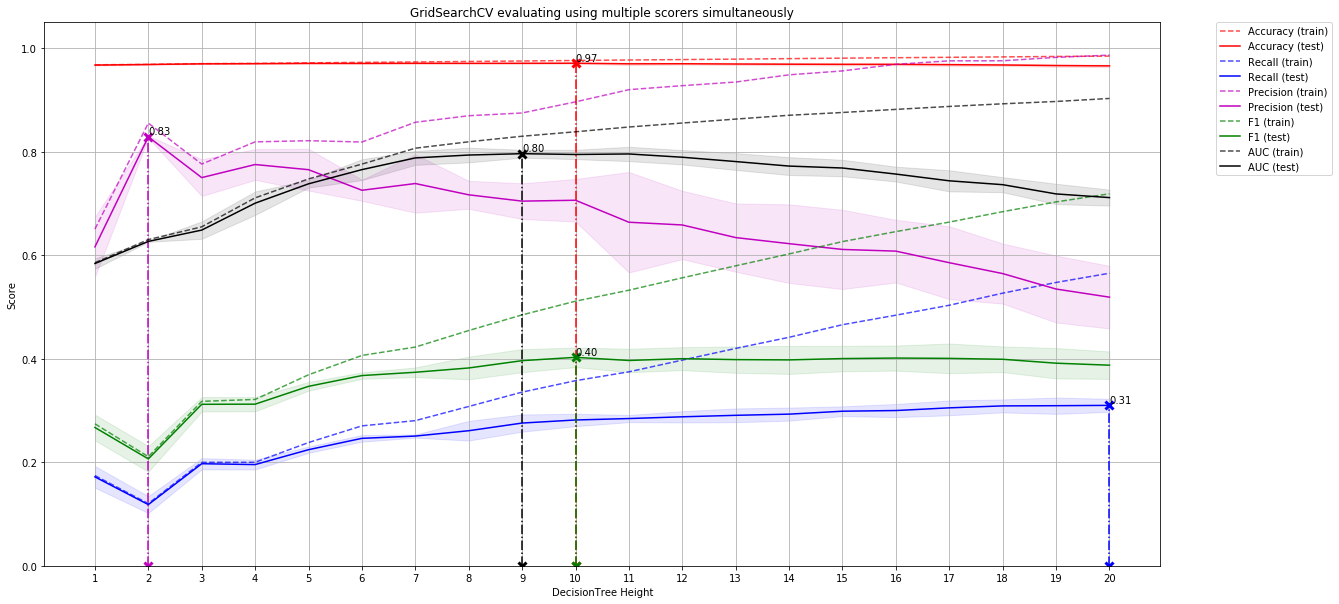

Exporting the optimal Decision Tree to ./data/results/approach2/tree ...
CPU times: user 24.4 s, sys: 2.17 s, total: 26.6 s
Wall time: 3min 56s


In [76]:
%%time
# Decision Tree
model_type = 'Decision Tree'
model, model_parameter_grid = instantiate(model_type)
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, X, y, crossvalidation, scoring_metrics)

In [77]:
save_load_model(1, 'dtree.pkl', grid_search_output, optimal_model)

In [79]:
optimal_model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [78]:
grid_search_output[['params', 'rank_test_AUC', 'mean_test_AUC', 'mean_test_Recall', 'mean_test_Precision', 'mean_test_Accuracy']]

,params,rank_test_AUC,mean_test_AUC,mean_test_Recall,mean_test_Precision,mean_test_Accuracy
0,{'max_depth': 1},20,0.583870,0.171757,0.616034,0.967144
1,{'max_depth': 2},19,0.626607,0.118232,0.828518,0.968290
2,{'max_depth': 3},18,0.648447,0.197165,0.749827,0.969585
3,{'max_depth': 4},17,0.700400,0.195519,0.775087,0.969865
4,{'max_depth': 5},13,0.737815,0.224265,0.765118,0.970419
5,{'max_depth': 6},10,0.765238,0.246189,0.725380,0.970349
6,{'max_depth': 7},6,0.787874,0.250593,0.738362,0.970607
7,{'max_depth': 8},4,0.793418,0.260901,0.716597,0.970519
8,{'max_depth': 9},1,0.796033,0.275709,0.704376,0.970612
9,{'max_depth': 10},3,0.794506,0.281662,0.706082,0.970750


In [80]:
print(optimal_model.predict_proba(X))
df_predictions = generate_predictions(df_test, model_features, optimal_model, './data/results/approach2/predictions_dtree.csv')

[[0.95613857 0.04386143]
 [0.98993828 0.01006172]
 [0.98993828 0.01006172]
 ...
 [0.98993828 0.01006172]
 [0.88496033 0.11503967]
 [0.98993828 0.01006172]]


In [81]:
Xt = df_test[model_features]
Xt.head()

,x0_C,x0_H,x0_R,x0_S,x0_W,C1,C13,C5,C9,D1,D10,D11,D15,D3,D5,TransactionAmt,V10,V100,V101,V102,V104,V105,V108,V109,V110,V111,V112,V113,V114,V115,V116,V12,V123,V124,V125,V129,V13,V130,V131,V135,V136,V137,V15,V169,V17,V170,V171,V174,V175,V176,V180,V181,V183,V184,V185,V186,V187,V188,V189,V19,V190,V191,V194,V195,V197,V198,V2,V20,V200,V201,V203,V208,V209,V210,V214,V215,V216,V218,V220,V221,V224,V226,V227,V228,V229,V23,V230,V234,V235,V238,V239,V24,V242,V243,V245,V246,V247,V248,V250,V252,V255,V257,V258,V259,V26,V260,V261,V262,V264,V267,V268,V270,V271,V274,V281,V282,V283,V284,V285,V287,V288,V289,V29,V290,V291,V297,V3,V300,V301,V302,V303,V309,V31,V310,V312,V313,V314,V315,V319,V320,V321,V35,V36,V37,V38,V39,V4,V40,V42,V44,V45,V46,V47,V48,V5,V51,V53,V54,V55,V56,V59,V61,V62,V64,V66,V67,V69,V7,V73,V75,V76,V77,V78,V79,V80,V82,V83,V85,V86,V87,V9,V90,V98,dist1,id_01,id_02,id_05,id_06
0,0.0,0.0,0.0,0.0,1.0,6.0,115.0,3.0,6.0,419.0,418.0,203.0,409.0,27.0,27.0,31.95,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.000000,0.0,47.950001,0.000000,0.0,0.0,0.0,0.0,0.168053,0.0,1.436779,1.690908,0.127794,0.212639,1.376979,0.924123,0.253332,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,0.0,1.213083,1.058984,0.945773,0.954227,0.949385,0.961951,1.0,0.0,1.119977,1.159106,1078.327538,8.888193,35.001872,14.391835,38.437547,133.208217,71.107143,1.725784,0.169472,1.274912,0.394748,0.247612,0.147975,1.351928,1.63871,1.0,1.465476,2.092847,0.184106,0.127956,0.136965,1.0,1.113463,1.178387,0.876619,1.183723,1.025355,1.069493,0.788588,1.032048,0.806656,1.250993,1.34351,0.967832,0.0,0.964425,1.107161,1.013279,201.657617,36.525103,18.813407,7.712764,9.445133,107.151636,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,47.950001,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,-10.170502,174716.584708,1.615585,-6.69871
1,0.0,0.0,0.0,0.0,1.0,3.0,12.0,0.0,2.0,149.0,231.0,634.0,634.0,7.0,7.0,49.00,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,280.000000,77.000000,0.0,0.0,0.0,0.0,0.168053,0.0,1.436779,1.690908,0.127794,0.212639,1.376979,0.924123,0.253332,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,1.0,1.213083,1.058984,0.945773,0.954227,0.949385,0.961951,1.0,1.0,1.119977,1.159106,1078.327538,8.888193,35.001872,14.391835,38.437547,133.208217,71.107143,1.725784,0.169472,1.274912,0.394748,0.247612,0.147975,1.351928,1.63871,1.0,1.465476,2.092847,0.184106,0.127956,0.136965,1.0,1.113463,1.178387,0.876619,1.183723,1.025355,1.069493,0.788588,1.032048,0.806656,1.250993,1.34351,0.967832,1.0,0.964425,1.107161,1.013279,201.657617,36.525103,18.813407,7.712764,9.445133,107.151636,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,280.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,4.0,-10.170502,174716.584708,1.615585,-6.69871
2,0.0,0.0,0.0,0.0,1.0,2.0,22.0,0.0,4.0,137.0,136.0,136.0,97.0,10.0,10.0,171.00,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,705.000000,0.000000,0.0,263.0,0.0,0.0,0.168053,0.0,1.436779,1.690908,0.127794,0.212639,1.376979,0.924123,0.253332,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,1.0,1.213083,1.058984,0.945773,0.954227,0.949385,0.961951,1.0,1.0,1.119977,1.159106,1078.327538,8.888193,35.001872,14.391835,38.437547,133.208217,71.107143,1.725784,0.169472,1.274912,0.394748,0.247612,0.147975,1.351928,1.63871,2.0,1.465476,2.092847,0.184106,0.127956,0.136965,2.0,1.113463,1.178387,0.876619,1.183723,1.025355,1.069493,0.788588,1.032048,0.806656,1.250993,1.34351,0.967832,1.0,0.964425,1.107161,1.013279,201.6576

### RandomForest

In [83]:
%%time
# Random Forest
model_type = 'Random Forest'
model, model_parameter_grid = instantiate(model_type)
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, X, y, crossvalidation, scoring_metrics)

Performing grid search to determine the optimal parameters ...
CPU times: user 43 s, sys: 5.74 s, total: 48.7 s
Wall time: 34min 17s


In [84]:
save_load_model(1, 'rf.pkl', grid_search_output, optimal_model)

In [85]:
optimal_model

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=20, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [86]:
grid_search_output[['params', 'rank_test_AUC', 'mean_test_AUC', 'mean_test_Recall', 'mean_test_Precision', 'mean_test_Accuracy']]

,params,rank_test_AUC,mean_test_AUC,mean_test_Recall,mean_test_Precision,mean_test_Accuracy
0,"{'max_depth': 5, 'n_estimators': 1}",216,0.774215,0.701445,0.081860,0.699831
1,"{'max_depth': 5, 'n_estimators': 2}",212,0.791121,0.701205,0.086099,0.713855
2,"{'max_depth': 5, 'n_estimators': 3}",204,0.806122,0.698834,0.095668,0.734448
3,"{'max_depth': 5, 'n_estimators': 4}",199,0.811606,0.722499,0.094458,0.726508
4,"{'max_depth': 5, 'n_estimators': 5}",194,0.816710,0.740455,0.088747,0.707520
5,"{'max_depth': 5, 'n_estimators': 6}",195,0.816677,0.739873,0.090786,0.713792
6,"{'max_depth': 5, 'n_estimators': 7}",191,0.818408,0.737163,0.091711,0.716903
7,"{'max_depth': 5, 'n_estimators': 8}",190,0.818422,0.732178,0.091423,0.717748
8,"{'max_depth': 5, 'n_estimators': 9}",183,0.822500,0.739002,0.092324,0.717225
9,"{'max_depth': 5, 'n_estimators': 10}",184,0.822120,0.728355,0.093142,0.722886


In [87]:
print(optimal_model.predict_proba(X))
df_predictions = generate_predictions(df_test, model_features, optimal_model, './data/results/approach2/predictions_rf.csv')

[[0.5799778  0.4200222 ]
 [0.72227452 0.27772548]
 [0.73411819 0.26588181]
 ...
 [0.87930436 0.12069564]
 [0.25011995 0.74988005]
 [0.81467393 0.18532607]]


In [88]:
len(optimal_model.feature_importances_)

188

In [89]:
df_feature_importance = pd.concat([pd.Series(X.columns).rename('features'), pd.Series(optimal_model.feature_importances_).rename('importance')], axis=1).sort_values('importance', ascending=False).reset_index(drop=True)
df_feature_importance['normalized_importance'] = df_feature_importance['importance'] / df_feature_importance['importance'].sum()
df_feature_importance['cumulative_importance'] = np.cumsum(df_feature_importance['normalized_importance'])

In [90]:
df_feature_importance[df_feature_importance['cumulative_importance'] <= 0.95]

,features,importance,normalized_importance,cumulative_importance
0,C5,0.065746,0.065746,0.065746
1,C13,0.057282,0.057282,0.123028
2,V283,0.044109,0.044109,0.167138
3,C1,0.039995,0.039995,0.207133
4,V102,0.035792,0.035792,0.242925
5,V257,0.033162,0.033162,0.276087
6,V171,0.027523,0.027523,0.303611
7,V246,0.027276,0.027276,0.330886
8,V73,0.026315,0.026315,0.357201
9,V69,0.025663,0.025663,0.382864


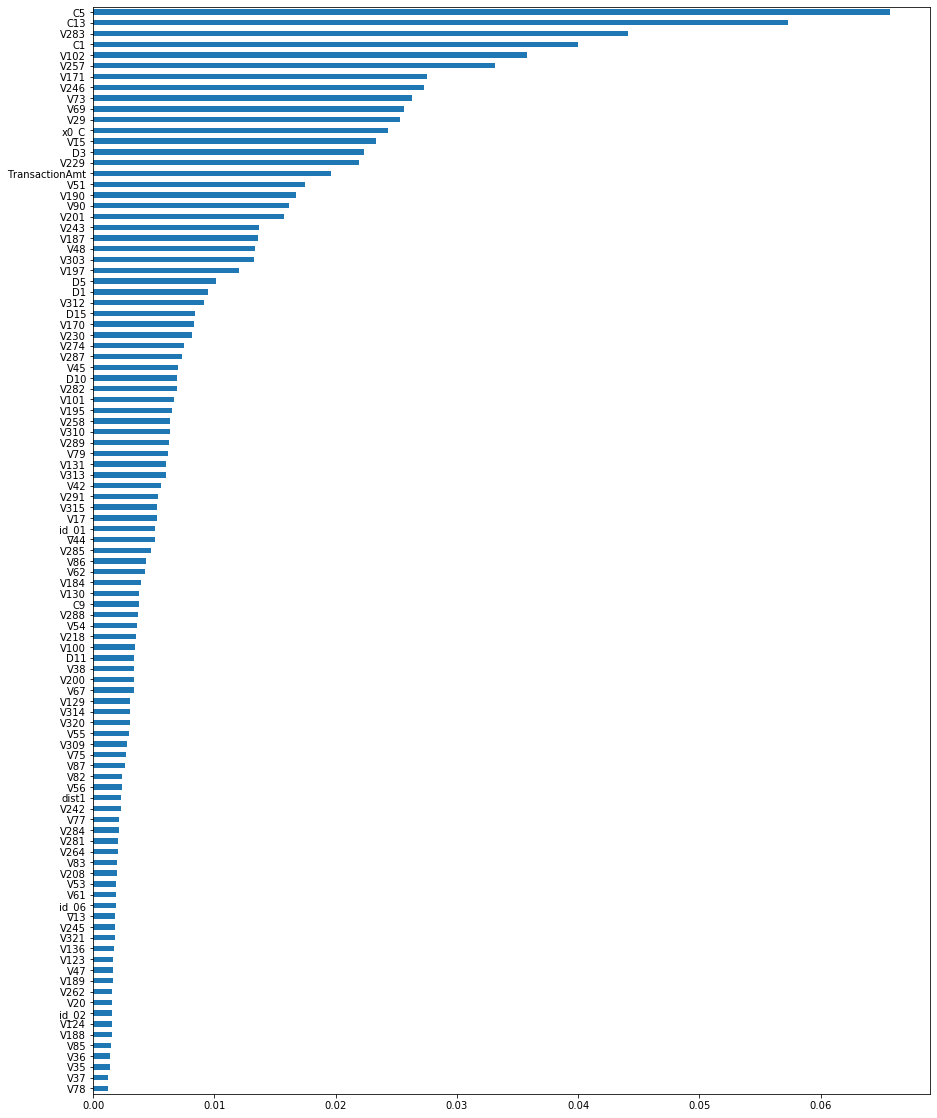

In [92]:
df_select = df_feature_importance[df_feature_importance['cumulative_importance'] <= 0.95]
fig = plt.figure(figsize=(15, 20))
ax = df_select['importance'][::-1].plot(kind='barh')
plt.yticks(range(len(df_select))[::-1], df_select['features'])
plt.show()

### XGBoost

In [93]:
%%time
# XGBoost
model_type = 'XGBoost'
model, model_parameter_grid = instantiate(model_type)
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, X, y, crossvalidation, scoring_metrics)

Performing grid search to determine the optimal parameters ...
CPU times: user 7min 32s, sys: 8.89 s, total: 7min 41s
Wall time: 1h 39min 42s


In [94]:
save_load_model(1, 'xgb.pkl', grid_search_output, optimal_model)

In [95]:
optimal_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [96]:
grid_search_output[['params', 'rank_test_AUC', 'mean_test_AUC', 'mean_test_Recall', 'mean_test_Precision', 'mean_test_Accuracy']]

,params,rank_test_AUC,mean_test_AUC,mean_test_Recall,mean_test_Precision,mean_test_Accuracy
0,"{'max_depth': 5, 'n_estimators': 5}",96,0.804253,0.222185,0.813109,0.970971
1,"{'max_depth': 5, 'n_estimators': 6}",95,0.805808,0.221604,0.809511,0.970915
2,"{'max_depth': 5, 'n_estimators': 7}",94,0.806174,0.221653,0.810856,0.970937
3,"{'max_depth': 5, 'n_estimators': 8}",93,0.806648,0.221507,0.815208,0.970982
4,"{'max_depth': 5, 'n_estimators': 9}",91,0.814982,0.222717,0.815137,0.971018
5,"{'max_depth': 5, 'n_estimators': 10}",87,0.822789,0.222185,0.815098,0.971005
6,"{'max_depth': 5, 'n_estimators': 11}",86,0.823432,0.223492,0.817894,0.971079
7,"{'max_depth': 5, 'n_estimators': 12}",82,0.827169,0.223347,0.816668,0.971062
8,"{'max_depth': 5, 'n_estimators': 13}",80,0.829551,0.225863,0.819932,0.971174
9,"{'max_depth': 5, 'n_estimators': 14}",77,0.830558,0.227073,0.815842,0.971159


In [97]:
print(optimal_model.predict_proba(X))
df_predictions = generate_predictions(df_test, model_features, optimal_model, './data/results/approach2/predictions_xgb.csv')

[[0.90474296 0.09525703]
 [0.9255885  0.07441153]
 [0.9255885  0.07441153]
 ...
 [0.9305723  0.06942774]
 [0.877437   0.122563  ]
 [0.9249873  0.07501266]]


In [98]:
df_feature_importance = pd.concat([pd.Series(X.columns).rename('features'), pd.Series(optimal_model.feature_importances_).rename('importance')], axis=1).sort_values('importance', ascending=False).reset_index(drop=True)
df_feature_importance['normalized_importance'] = df_feature_importance['importance'] / df_feature_importance['importance'].sum()
df_feature_importance['cumulative_importance'] = np.cumsum(df_feature_importance['normalized_importance'])

In [99]:
df_feature_importance[df_feature_importance['cumulative_importance'] <= 0.95]

,features,importance,normalized_importance,cumulative_importance
0,V258,0.221232,0.221232,0.221232
1,V102,0.026353,0.026353,0.247585
2,V283,0.025645,0.025645,0.273230
3,V189,0.022405,0.022405,0.295635
4,V90,0.020394,0.020394,0.316029
5,x0_C,0.019163,0.019163,0.335193
6,C13,0.016674,0.016674,0.351866
7,V201,0.016546,0.016546,0.368412
8,x0_W,0.015868,0.015868,0.384280
9,V187,0.015332,0.015332,0.399612


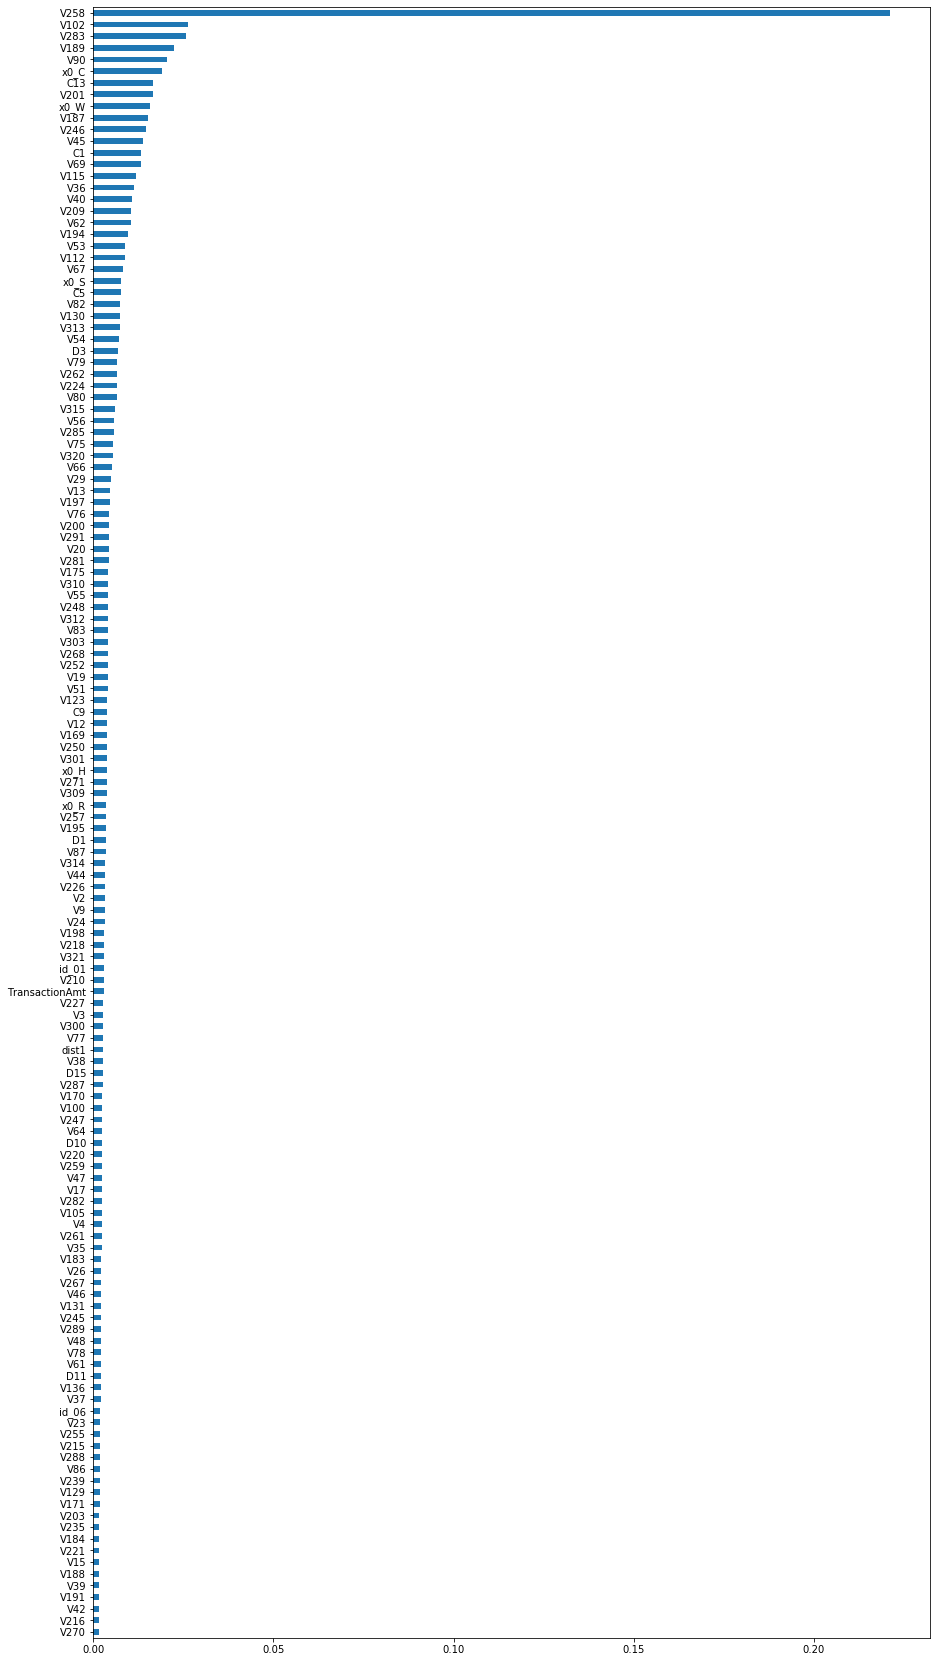

In [102]:
df_select = df_feature_importance[df_feature_importance['cumulative_importance'] <= 0.95]
fig = plt.figure(figsize=(15, 30))
ax = df_select['importance'][::-1].plot(kind='barh')
plt.yticks(range(len(df_select))[::-1], df_select['features'])
plt.show()

## Modelling Imbalanced Data

### Oversampling the minority class (failure = 1)

In [102]:
X = df_train[model_features].copy()
y = df_train['isFraud'].copy()

print(X.shape)
X.head()

(590540, 188)


,x0_C,x0_H,x0_R,x0_S,x0_W,C1,C13,C5,C9,D1,D10,D11,D15,D3,D5,TransactionAmt,V10,V100,V101,V102,V104,V105,V108,V109,V110,V111,V112,V113,V114,V115,V116,V12,V123,V124,V125,V129,V13,V130,V131,V135,V136,V137,V15,V169,V17,V170,V171,V174,V175,V176,V180,V181,V183,V184,V185,V186,V187,V188,V189,V19,V190,V191,V194,V195,V197,V198,V2,V20,V200,V201,V203,V208,V209,V210,V214,V215,V216,V218,V220,V221,V224,V226,V227,V228,V229,V23,V230,V234,V235,V238,V239,V24,V242,V243,V245,V246,V247,V248,V250,V252,V255,V257,V258,V259,V26,V260,V261,V262,V264,V267,V268,V270,V271,V274,V281,V282,V283,V284,V285,V287,V288,V289,V29,V290,V291,V297,V3,V300,V301,V302,V303,V309,V31,V310,V312,V313,V314,V315,V319,V320,V321,V35,V36,V37,V38,V39,V4,V40,V42,V44,V45,V46,V47,V48,V5,V51,V53,V54,V55,V56,V59,V61,V62,V64,V66,V67,V69,V7,V73,V75,V76,V77,V78,V79,V80,V82,V83,V85,V86,V87,V9,V90,V98,dist1,id_01,id_02,id_05,id_06
0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,14.0,13.000000,13.000000,0.000000,13.000000,42.335965,68.5,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.168053,0.00000,1.436779,1.690908,0.127794,0.212639,1.376979,0.924123,0.253332,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,1.000000,1.213083,1.058984,0.945773,0.954227,0.949385,0.961951,1.000000,1.000000,1.119977,1.159106,1078.327538,8.888193,35.001872,14.391835,38.437547,133.208217,71.107143,1.725784,0.169472,1.274912,0.394748,0.247612,0.147975,1.351928,1.63871,1.000000,1.465476,2.092847,0.184106,0.127956,0.136965,1.000000,1.113463,1.178387,0.876619,1.183723,1.025355,1.069493,0.788588,1.032048,0.806656,1.250993,1.34351,0.967832,1.00000,0.964425,1.107161,1.013279,201.657617,36.525103,18.813407,7.712764,9.445133,107.151636,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.542594,0.579198,1.108065,1.1624,0.166076,1.000000,0.177145,0.156118,1.083891,1.120779,1.022286,1.038515,0.383174,1.000000,0.170579,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.0000,1.00000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.0,19.00000,-10.170502,174716.584708,1.615585,-6.69871
1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,146.621465,0.000000,28.343348,42.335965,29.0,0.463915,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.168053,0.00000,1.436779,1.690908,0.127794,0.212639,1.376979,0.924123,0.253332,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,1.000000,1.213083,1.058984,0.945773,0.954227,0.949385,0.961951,1.045204,1.000000,1.119977,1.159106,1078.327538,8.888193,35.001872,14.391835,38.437547,133.208217,71.107143,1.725784,0.169472,1.274912,0.394748,0.247612,0.147975,1.351928,1.63871,1.000000,1.465476,2.092847,0.184106,0.127956,0.136965,1.000000,1.113463,1.178387,0.876619,1.183723,1.025355,1.069493,0.788588,1.032048,0.806656,1.250993,1.34351,0.967832,1.00000,0.964425,1.107161,1.013279,201.657617,36.525103,18.813407,7.712764,9.445133,107.151636,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,1.0,0.0,1.078075,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,1.0000,0.000000,0.846456,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.876991,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.0000,1.07287,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,1.000000,0.000000,1.000000,1.000000,1.041529,0.000000,0.0,118.50218,-10.170502,174716.584708,1.615585,-6.69871
2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.000000,315.000000,315.000000,28.343348,42.335965,59.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.168053,0.00000,1.436779,1.690908,0.127794,0.212639,1.376979,0.92

In [103]:
Xt = df_test[model_features]

print(Xt.shape)
Xt.head()

(506691, 188)


,x0_C,x0_H,x0_R,x0_S,x0_W,C1,C13,C5,C9,D1,D10,D11,D15,D3,D5,TransactionAmt,V10,V100,V101,V102,V104,V105,V108,V109,V110,V111,V112,V113,V114,V115,V116,V12,V123,V124,V125,V129,V13,V130,V131,V135,V136,V137,V15,V169,V17,V170,V171,V174,V175,V176,V180,V181,V183,V184,V185,V186,V187,V188,V189,V19,V190,V191,V194,V195,V197,V198,V2,V20,V200,V201,V203,V208,V209,V210,V214,V215,V216,V218,V220,V221,V224,V226,V227,V228,V229,V23,V230,V234,V235,V238,V239,V24,V242,V243,V245,V246,V247,V248,V250,V252,V255,V257,V258,V259,V26,V260,V261,V262,V264,V267,V268,V270,V271,V274,V281,V282,V283,V284,V285,V287,V288,V289,V29,V290,V291,V297,V3,V300,V301,V302,V303,V309,V31,V310,V312,V313,V314,V315,V319,V320,V321,V35,V36,V37,V38,V39,V4,V40,V42,V44,V45,V46,V47,V48,V5,V51,V53,V54,V55,V56,V59,V61,V62,V64,V66,V67,V69,V7,V73,V75,V76,V77,V78,V79,V80,V82,V83,V85,V86,V87,V9,V90,V98,dist1,id_01,id_02,id_05,id_06
0,0.0,0.0,0.0,0.0,1.0,6.0,115.0,3.0,6.0,419.0,418.0,203.0,409.0,27.0,27.0,31.95,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.000000,0.0,47.950001,0.000000,0.0,0.0,0.0,0.0,0.168053,0.0,1.436779,1.690908,0.127794,0.212639,1.376979,0.924123,0.253332,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,0.0,1.213083,1.058984,0.945773,0.954227,0.949385,0.961951,1.0,0.0,1.119977,1.159106,1078.327538,8.888193,35.001872,14.391835,38.437547,133.208217,71.107143,1.725784,0.169472,1.274912,0.394748,0.247612,0.147975,1.351928,1.63871,1.0,1.465476,2.092847,0.184106,0.127956,0.136965,1.0,1.113463,1.178387,0.876619,1.183723,1.025355,1.069493,0.788588,1.032048,0.806656,1.250993,1.34351,0.967832,0.0,0.964425,1.107161,1.013279,201.657617,36.525103,18.813407,7.712764,9.445133,107.151636,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,47.950001,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,-10.170502,174716.584708,1.615585,-6.69871
1,0.0,0.0,0.0,0.0,1.0,3.0,12.0,0.0,2.0,149.0,231.0,634.0,634.0,7.0,7.0,49.00,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,280.000000,77.000000,0.0,0.0,0.0,0.0,0.168053,0.0,1.436779,1.690908,0.127794,0.212639,1.376979,0.924123,0.253332,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,1.0,1.213083,1.058984,0.945773,0.954227,0.949385,0.961951,1.0,1.0,1.119977,1.159106,1078.327538,8.888193,35.001872,14.391835,38.437547,133.208217,71.107143,1.725784,0.169472,1.274912,0.394748,0.247612,0.147975,1.351928,1.63871,1.0,1.465476,2.092847,0.184106,0.127956,0.136965,1.0,1.113463,1.178387,0.876619,1.183723,1.025355,1.069493,0.788588,1.032048,0.806656,1.250993,1.34351,0.967832,1.0,0.964425,1.107161,1.013279,201.657617,36.525103,18.813407,7.712764,9.445133,107.151636,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,280.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,4.0,-10.170502,174716.584708,1.615585,-6.69871
2,0.0,0.0,0.0,0.0,1.0,2.0,22.0,0.0,4.0,137.0,136.0,136.0,97.0,10.0,10.0,171.00,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,705.000000,0.000000,0.0,263.0,0.0,0.0,0.168053,0.0,1.436779,1.690908,0.127794,0.212639,1.376979,0.924123,0.253332,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,1.0,1.213083,1.058984,0.945773,0.954227,0.949385,0.961951,1.0,1.0,1.119977,1.159106,1078.327538,8.888193,35.001872,14.391835,38.437547,133.208217,71.107143,1.725784,0.169472,1.274912,0.394748,0.247612,0.147975,1.351928,1.63871,2.0,1.465476,2.092847,0.184106,0.127956,0.136965,2.0,1.113463,1.178387,0.876619,1.183723,1.025355,1.069493,0.788588,1.032048,0.806656,1.250993,1.34351,0.967832,1.0,0.964425,1.107161,1.013279,201.6576

In [128]:
# Oversampling the failure = 1 class using SMPOTE method
def oversample(X, y):
    # apply SMOTE
    method = SMOTE(kind='regular')
    X_res, y_res = method.fit_sample(X, y)

    Xnew = pd.DataFrame(X_res)
    Xnew.columns = X.columns
    ynew = pd.Series(y_res)
    return Xnew, ynew

In [145]:
def pca_transformation(X, n=2):
    pca = PCA(n_components = n)
    pca.fit(X)
    return (pca)

In [154]:
def plot_resampling(ax, X, y, title, Xtest=None):
    c0 = ax.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, s=2, color='green')
    c1 = ax.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, s=2, color='red')
    
    if Xtest is not None:
        ax.scatter(Xtest[:, 0], Xtest[:, 1], label="test", alpha=0.5, s=2, color='black')
        
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

    return c0, c1

In [202]:
# To compare the given and oversampled datasets, we perform a PCA and project the data
# into the two directions of maximum variance. This is done before and after sampling
# from the minority class. THe resulting projections are then plotted to see the difference.
def plot_smote_2d(X, y, Xnew, ynew, pca, Xtest=None):
    X_vis = pca.transform(X)
    Xnew_vis = pca.transform(Xnew)
    
    Xtest_vis = None
    if Xtest is not None:
        Xtest_vis = pca.transform(Xtest)
    
    # generate comparison data plots
    f, (ax1, ax2) = plt.subplots(1, 2)
    c0, c1 = plot_resampling(ax1, X_vis, y, 'Original', Xtest_vis)
    ax1.legend((c0, c1), ('Class #0', 'Class #1'))
    
    c0, c1 = plot_resampling(ax2, Xnew_vis, ynew, 'SMOTE', Xtest_vis)
    ax2.legend((c0, c1), ('Class #0', 'Class #1'))
    
    if Xtest is not None:
        ax1.set_ylim(0, 140000)
        ax2.set_ylim(0, 140000)
        
    plt.tight_layout()
    plt.show()
    
    #return ((ax1, ax2))

In [119]:
%%time
Xnew, ynew = oversample(X, y)

CPU times: user 18.9 s, sys: 1.89 s, total: 20.8 s
Wall time: 16 s


In [130]:
Xnew.head()

,x0_C,x0_H,x0_R,x0_S,x0_W,C1,C13,C5,C9,D1,D10,D11,D15,D3,D5,TransactionAmt,V10,V100,V101,V102,V104,V105,V108,V109,V110,V111,V112,V113,V114,V115,V116,V12,V123,V124,V125,V129,V13,V130,V131,V135,V136,V137,V15,V169,V17,V170,V171,V174,V175,V176,V180,V181,V183,V184,V185,V186,V187,V188,V189,V19,V190,V191,V194,V195,V197,V198,V2,V20,V200,V201,V203,V208,V209,V210,V214,V215,V216,V218,V220,V221,V224,V226,V227,V228,V229,V23,V230,V234,V235,V238,V239,V24,V242,V243,V245,V246,V247,V248,V250,V252,V255,V257,V258,V259,V26,V260,V261,V262,V264,V267,V268,V270,V271,V274,V281,V282,V283,V284,V285,V287,V288,V289,V29,V290,V291,V297,V3,V300,V301,V302,V303,V309,V31,V310,V312,V313,V314,V315,V319,V320,V321,V35,V36,V37,V38,V39,V4,V40,V42,V44,V45,V46,V47,V48,V5,V51,V53,V54,V55,V56,V59,V61,V62,V64,V66,V67,V69,V7,V73,V75,V76,V77,V78,V79,V80,V82,V83,V85,V86,V87,V9,V90,V98,dist1,id_01,id_02,id_05,id_06
0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,14.0,13.000000,13.000000,0.000000,13.000000,42.335965,68.5,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.168053,0.00000,1.436779,1.690908,0.127794,0.212639,1.376979,0.924123,0.253332,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,1.000000,1.213083,1.058984,0.945773,0.954227,0.949385,0.961951,1.000000,1.000000,1.119977,1.159106,1078.327538,8.888193,35.001872,14.391835,38.437547,133.208217,71.107143,1.725784,0.169472,1.274912,0.394748,0.247612,0.147975,1.351928,1.63871,1.000000,1.465476,2.092847,0.184106,0.127956,0.136965,1.000000,1.113463,1.178387,0.876619,1.183723,1.025355,1.069493,0.788588,1.032048,0.806656,1.250993,1.34351,0.967832,1.00000,0.964425,1.107161,1.013279,201.657617,36.525103,18.813407,7.712764,9.445133,107.151636,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.542594,0.579198,1.108065,1.1624,0.166076,1.000000,0.177145,0.156118,1.083891,1.120779,1.022286,1.038515,0.383174,1.000000,0.170579,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.0000,1.00000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.0,19.00000,-10.170502,174716.584708,1.615585,-6.69871
1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,146.621465,0.000000,28.343348,42.335965,29.0,0.463915,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.168053,0.00000,1.436779,1.690908,0.127794,0.212639,1.376979,0.924123,0.253332,0.484692,0.132364,0.173903,1.148799,1.843752,1.014755,1.038314,1.000000,1.213083,1.058984,0.945773,0.954227,0.949385,0.961951,1.045204,1.000000,1.119977,1.159106,1078.327538,8.888193,35.001872,14.391835,38.437547,133.208217,71.107143,1.725784,0.169472,1.274912,0.394748,0.247612,0.147975,1.351928,1.63871,1.000000,1.465476,2.092847,0.184106,0.127956,0.136965,1.000000,1.113463,1.178387,0.876619,1.183723,1.025355,1.069493,0.788588,1.032048,0.806656,1.250993,1.34351,0.967832,1.00000,0.964425,1.107161,1.013279,201.657617,36.525103,18.813407,7.712764,9.445133,107.151636,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,1.0,0.0,1.078075,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,1.0000,0.000000,0.846456,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.876991,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.0000,1.07287,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,1.000000,0.000000,1.000000,1.000000,1.041529,0.000000,0.0,118.50218,-10.170502,174716.584708,1.615585,-6.69871
2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.000000,315.000000,315.000000,28.343348,42.335965,59.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.168053,0.00000,1.436779,1.690908,0.127794,0.212639,1.376979,0.92

In [120]:
print(y.value_counts())
print(ynew.value_counts())

0    569877
1     20663
Name: isFraud, dtype: int64
1    569877
0    569877
dtype: int64


In [147]:
%%time
pca = pca_transformation(X, 2)

CPU times: user 13.1 s, sys: 1.74 s, total: 14.8 s
Wall time: 2.54 s


CPU times: user 11.5 s, sys: 1.94 s, total: 13.5 s
Wall time: 9.9 s


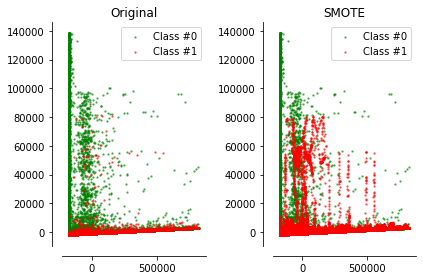

In [173]:
%%time
plot_smote_2d(X, y, Xnew, ynew, pca)

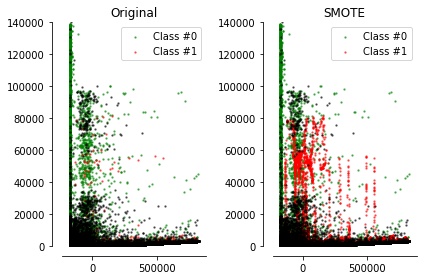

CPU times: user 43.1 s, sys: 4.16 s, total: 47.2 s
Wall time: 42 s


(<matplotlib.axes._subplots.AxesSubplot at 0x7fee8bb669e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fefd8867780>)

In [201]:
%%time
plot_smote_2d(X, y, Xnew, ynew, pca, Xt)

In [204]:
np.sum(pca.explained_variance_ratio_) 

0.9994829595694339

# SMOTE + Construction of ML Models

Performing grid search to determine the optimal parameters ...


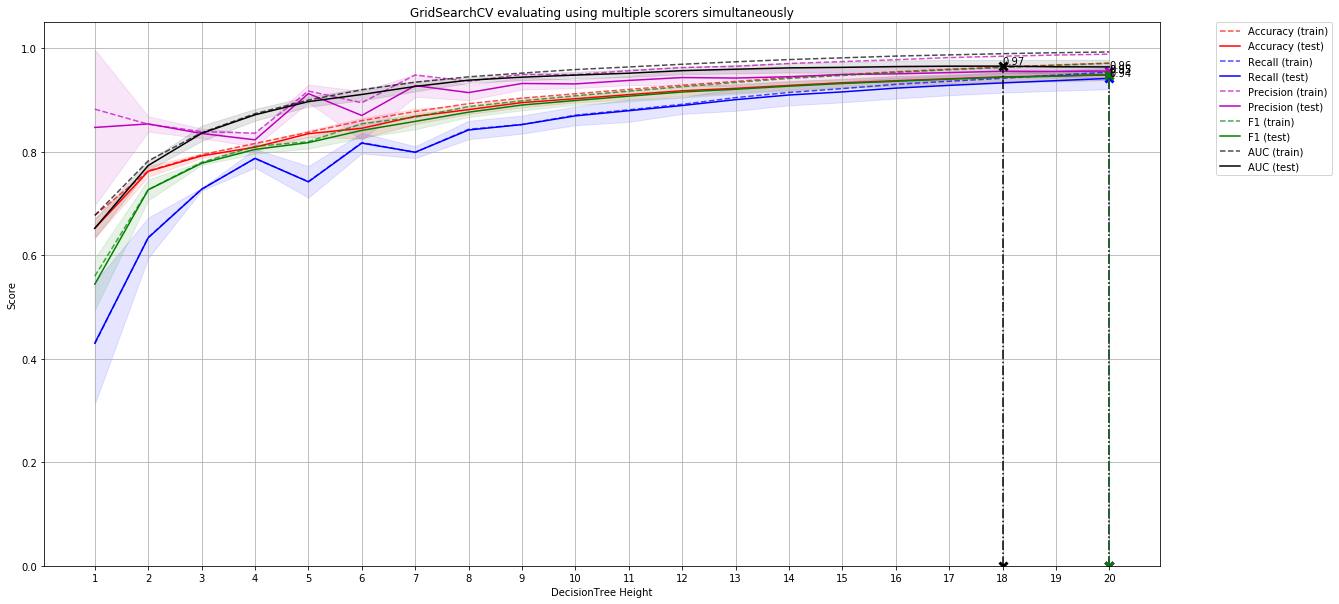

Exporting the optimal Decision Tree to ./data/results/approach2/tree ...
CPU times: user 4min 3s, sys: 4.69 s, total: 4min 7s
Wall time: 19min 27s


In [140]:
%%time
# Decision Tree
model_type = 'Decision Tree'
model, model_parameter_grid = instantiate(model_type)
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, Xnew, ynew, crossvalidation, scoring_metrics)

In [141]:
save_load_model(1, 'smote_dtree.pkl', grid_search_output, optimal_model)

In [142]:
optimal_model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=18,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [143]:
grid_search_output[['params', 'rank_test_AUC', 'mean_test_AUC', 'mean_test_Recall', 'mean_test_Precision', 'mean_test_Accuracy']]

,params,rank_test_AUC,mean_test_AUC,mean_test_Recall,mean_test_Precision,mean_test_Accuracy
0,{'max_depth': 1},20,0.651949,0.430175,0.846701,0.651949
1,{'max_depth': 2},19,0.773181,0.633607,0.853519,0.761964
2,{'max_depth': 3},18,0.835318,0.727204,0.835103,0.791737
3,{'max_depth': 4},17,0.871117,0.787044,0.822791,0.808554
4,{'max_depth': 5},16,0.896608,0.741630,0.912094,0.834616
5,{'max_depth': 6},15,0.910376,0.816422,0.869804,0.845089
6,{'max_depth': 7},14,0.925947,0.798869,0.927597,0.868137
7,{'max_depth': 8},13,0.938022,0.841778,0.914044,0.881123
8,{'max_depth': 9},12,0.943844,0.852256,0.931624,0.894765
9,{'max_depth': 10},11,0.947847,0.869065,0.930808,0.902153


In [144]:
print(optimal_model.predict_proba(X))
df_predictions = generate_predictions(df_test, model_features, optimal_model, './data/results/approach2/predictions_smote_dtree.csv')

[[0.94198044 0.05801956]
 [0.86413835 0.13586165]
 [0.86413835 0.13586165]
 ...
 [0.98648996 0.01351004]
 [0.80645161 0.19354839]
 [0.97530864 0.02469136]]


# PCA

In [205]:
pca2 = PCA(n_components = 'mle')
pca2.fit(X)

PCA(copy=True, iterated_power='auto', n_components='mle', random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [211]:
pca2.explained_variance_ratio_[0:10]

array([9.96221358e-01, 3.26160193e-03, 2.55238229e-04, 1.01580058e-04,
       4.02560391e-05, 2.56672746e-05, 1.35196267e-05, 1.28135285e-05,
       9.76347142e-06, 9.08297400e-06])

In [210]:
X.shape

(590540, 188)

In [213]:
%%time
pca = pca_transformation(X, 2)

CPU times: user 13 s, sys: 1.69 s, total: 14.6 s
Wall time: 2.52 s


In [222]:
X2 = pd.DataFrame(pca.transform(X), columns=['pc1', 'pc2'])
Xt2 = pd.DataFrame(pca.transform(Xt), columns=['pc1', 'pc2'])
df_test2 = Xt2.copy()
df_test2['TransactionID'] = df_test['TransactionID']

### Decision Tree

Performing grid search to determine the optimal parameters ...


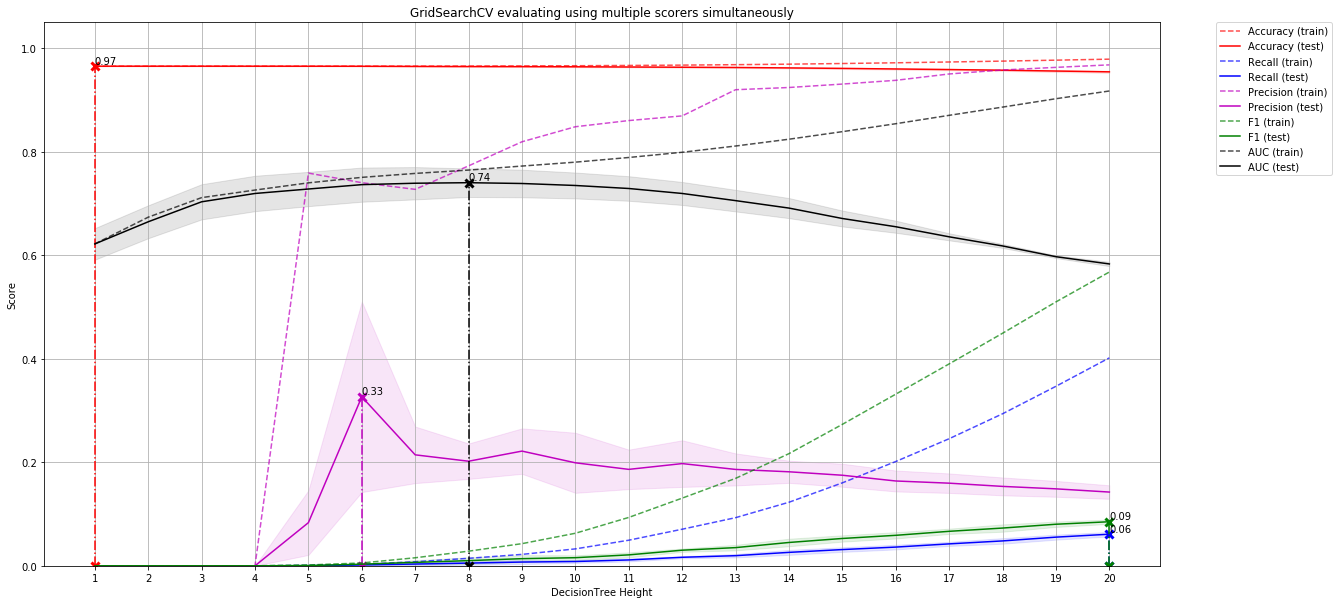

Exporting the optimal Decision Tree to ./data/results/approach2/tree ...
CPU times: user 6.48 s, sys: 649 ms, total: 7.13 s
Wall time: 26.5 s


In [224]:
%%time
# Decision Tree
model_type = 'Decision Tree'
model, model_parameter_grid = instantiate(model_type)
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, X2, y, crossvalidation, scoring_metrics)

In [225]:
save_load_model(1, 'pca_dtree.pkl', grid_search_output, optimal_model)

In [226]:
optimal_model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [227]:
grid_search_output[['params', 'rank_test_AUC', 'mean_test_AUC', 'mean_test_Recall', 'mean_test_Precision', 'mean_test_Accuracy']]

,params,rank_test_AUC,mean_test_AUC,mean_test_Recall,mean_test_Precision,mean_test_Accuracy
0,{'max_depth': 1},17,0.621674,0.000000,0.000000,0.965010
1,{'max_depth': 2},14,0.664501,0.000000,0.000000,0.965010
2,{'max_depth': 3},11,0.703089,0.000000,0.000000,0.965010
3,{'max_depth': 4},9,0.719169,0.000000,0.000000,0.965010
4,{'max_depth': 5},7,0.727789,0.000242,0.083333,0.964959
5,{'max_depth': 6},4,0.736235,0.001597,0.326445,0.964868
6,{'max_depth': 7},2,0.738955,0.003388,0.214330,0.964592
7,{'max_depth': 8},1,0.740001,0.005227,0.202000,0.964331
8,{'max_depth': 9},3,0.738448,0.007259,0.221552,0.964175
9,{'max_depth': 10},5,0.734610,0.008276,0.198957,0.963875


In [228]:
print(optimal_model.predict_proba(X2))
df_predictions = generate_predictions(df_test2, ['pc1', 'pc2'], optimal_model, './data/results/approach2/predictions_pca_dtree.csv')

[[0.97970246 0.02029754]
 [0.99077383 0.00922617]
 [0.98858277 0.01141723]
 ...
 [0.99077383 0.00922617]
 [0.95932257 0.04067743]
 [0.95390295 0.04609705]]


### XGBoost

In [229]:
%%time
# XGBoost
model_type = 'XGBoost'
model, model_parameter_grid = instantiate(model_type)
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, X2, y, crossvalidation, scoring_metrics)

Performing grid search to determine the optimal parameters ...
CPU times: user 26.9 s, sys: 1.49 s, total: 28.4 s
Wall time: 6min 11s


In [230]:
save_load_model(1, 'pca_xgb.pkl', grid_search_output, optimal_model)

In [231]:
optimal_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [232]:
grid_search_output[['params', 'rank_test_AUC', 'mean_test_AUC', 'mean_test_Recall', 'mean_test_Precision', 'mean_test_Accuracy']]

,params,rank_test_AUC,mean_test_AUC,mean_test_Recall,mean_test_Precision,mean_test_Accuracy
0,"{'max_depth': 5, 'n_estimators': 5}",96,0.734623,0.000000,0.000000,0.964990
1,"{'max_depth': 5, 'n_estimators': 6}",95,0.735588,0.000000,0.000000,0.965010
2,"{'max_depth': 5, 'n_estimators': 7}",94,0.735664,0.000000,0.000000,0.965010
3,"{'max_depth': 5, 'n_estimators': 8}",93,0.736404,0.000000,0.000000,0.965010
4,"{'max_depth': 5, 'n_estimators': 9}",92,0.737050,0.000000,0.000000,0.964995
5,"{'max_depth': 5, 'n_estimators': 10}",91,0.737564,0.000000,0.000000,0.965010
6,"{'max_depth': 5, 'n_estimators': 11}",90,0.738972,0.000000,0.000000,0.965010
7,"{'max_depth': 5, 'n_estimators': 12}",89,0.739313,0.000000,0.000000,0.965010
8,"{'max_depth': 5, 'n_estimators': 13}",88,0.739497,0.000097,0.083333,0.965003
9,"{'max_depth': 5, 'n_estimators': 14}",87,0.739739,0.000097,0.083333,0.965003


In [233]:
print(optimal_model.predict_proba(X2))
df_predictions = generate_predictions(df_test2, ['pc1', 'pc2'], optimal_model, './data/results/approach2/predictions_pca_xgb.csv')

[[0.91561943 0.08438057]
 [0.9269208  0.07307926]
 [0.9268702  0.07312974]
 ...
 [0.9269208  0.07307926]
 [0.88574284 0.11425715]
 [0.8972793  0.10272069]]


### RandomForest

In [234]:
%%time
# Random Forest
model_type = 'Random Forest'
model, model_parameter_grid = instantiate(model_type)
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, X2, y, crossvalidation, scoring_metrics)

Performing grid search to determine the optimal parameters ...
CPU times: user 1min 22s, sys: 3.62 s, total: 1min 25s
Wall time: 18min 37s


In [235]:
save_load_model(1, 'pca_rf.pkl', grid_search_output, optimal_model)

In [236]:
optimal_model

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=20, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [237]:
grid_search_output[['params', 'rank_test_AUC', 'mean_test_AUC', 'mean_test_Recall', 'mean_test_Precision', 'mean_test_Accuracy']]

,params,rank_test_AUC,mean_test_AUC,mean_test_Recall,mean_test_Precision,mean_test_Accuracy
0,"{'max_depth': 5, 'n_estimators': 1}",198,0.722492,0.689976,0.071220,0.665039
1,"{'max_depth': 5, 'n_estimators': 2}",176,0.729407,0.668102,0.071710,0.679023
2,"{'max_depth': 5, 'n_estimators': 3}",164,0.733158,0.664521,0.072846,0.684433
3,"{'max_depth': 5, 'n_estimators': 4}",149,0.736586,0.669022,0.072564,0.681492
4,"{'max_depth': 5, 'n_estimators': 5}",150,0.736554,0.659440,0.072408,0.686812
5,"{'max_depth': 5, 'n_estimators': 6}",147,0.736927,0.665682,0.072332,0.683031
6,"{'max_depth': 5, 'n_estimators': 7}",148,0.736840,0.662150,0.072349,0.684186
7,"{'max_depth': 5, 'n_estimators': 8}",143,0.737507,0.648888,0.073616,0.694210
8,"{'max_depth': 5, 'n_estimators': 9}",142,0.737834,0.652954,0.073766,0.693050
9,"{'max_depth': 5, 'n_estimators': 10}",139,0.738358,0.652034,0.073704,0.693105


In [238]:
print(optimal_model.predict_proba(X2))
df_predictions = generate_predictions(df_test2, ['pc1', 'pc2'], optimal_model, './data/results/approach2/predictions_pca_rf.csv')

[[0.63745773 0.36254227]
 [0.8434881  0.1565119 ]
 [0.79274143 0.20725857]
 ...
 [0.85657462 0.14342538]
 [0.45085093 0.54914907]
 [0.49471131 0.50528869]]
